In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
sales = pd.read_csv('../data/raw/sales_train.csv')
shops = pd.read_csv('../data/raw/shops.csv')
items = pd.read_csv('../data/raw/items.csv')
item_cat = pd.read_csv('../data/raw/item_categories.csv')

## Sales

According to data dictionary, `sales_train.csv` contains daily historical data from January 2013 to October 2015.
* *date* - date in format dd/mm/yyyy
* *date_block_num* - a consecutive month number, used for convenience. January 2013 is 0, February 2013 is 1,..., October 2015 is 33
* *shop_id* - unique identifier of a shop
* *item_id* - unique identifier of a product
* *item_price* - current price of an item
* *item_cnt_day* - number of products sold. You are predicting a monthly amount of this measure




In [3]:
sales.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


In [4]:
sales[sales.duplicated(subset=['date','shop_id','item_id'])].shape

(28, 6)

There're some duplicates present. That means the *same* item was sold at the *same* shop multiple time in *one* day. We can sum these purchases into one, and handle different prices by replacing them with a median.This sutiation needs to be handled in ETL.

In [5]:
sales.isna().any()

date              False
date_block_num    False
shop_id           False
item_id           False
item_price        False
item_cnt_day      False
dtype: bool

No NaN values.

In [6]:
sales.info() #checking appropriate datatypes

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 6 columns):
 #   Column          Dtype  
---  ------          -----  
 0   date            object 
 1   date_block_num  int64  
 2   shop_id         int64  
 3   item_id         int64  
 4   item_price      float64
 5   item_cnt_day    float64
dtypes: float64(2), int64(3), object(1)
memory usage: 134.4+ MB


### Dates

In [7]:
# converting date from object to datetime 
sales['date'] = pd.to_datetime(sales['date'], format="%d.%m.%Y")

In [8]:
min_date = sales['date'].min()
max_date = sales['date'].max()
print(f'Min date: {min_date}\nMax date: {max_date}')

Min date: 2013-01-01 00:00:00
Max date: 2015-10-31 00:00:00


In [9]:
sales['date_block_num'].nunique()

34

### Price

In [10]:
min_price = sales['item_price'].min()
max_price = sales['item_price'].max()
mean_price = sales['item_price'].mean()
median_price = sales['item_price'].median()
print(f'Min price: {min_price}\nMax price: {max_price}\nMean price: {mean_price}\nMedian price: {median_price}')

Min price: -1.0
Max price: 307980.0
Mean price: 890.8532326979881
Median price: 399.0


There are negative prices, max price might be an outliar

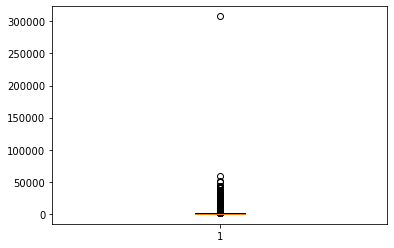

In [11]:
plt.boxplot(sales['item_price']); 

The 300000+ point is way too far and it seems to be the only observation with such high value.

We can explore the samples with high values and see if they make sense or are just a result of some sort of error.

In [12]:
ind = sales['item_price'].sort_values(ascending=False)[:20].index # taking 20 most pricy samples
sales.loc[ind].merge(items, on='item_id')

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_name,item_category_id
0,2013-12-13,11,12,6066,307980.0,1.0,Radmin 3 - 522 лиц.,75
1,2013-09-17,8,12,11365,59200.0,1.0,Доставка (EMS),9
2,2014-03-20,14,25,13199,50999.0,1.0,Коллекционные шахматы (Властелин Колец),69
3,2015-01-29,24,12,7241,49782.0,1.0,UserGate Proxy & Firewall 6.X с модулем фильтр...,75
4,2015-10-20,33,22,13403,42990.0,1.0,"Комплект ""Microsoft Xbox One 1TB Limited Edit...",16
5,2015-10-20,33,3,13403,42990.0,1.0,"Комплект ""Microsoft Xbox One 1TB Limited Edit...",16
6,2015-10-29,33,12,13403,42990.0,1.0,"Комплект ""Microsoft Xbox One 1TB Limited Edit...",16
7,2015-10-23,33,42,13403,42990.0,1.0,"Комплект ""Microsoft Xbox One 1TB Limited Edit...",16
8,2015-10-20,33,12,13403,41990.0,1.0,"Комплект ""Microsoft Xbox One 1TB Limited Edit...",16
9,2015-10-20,33,38,13403,41990.0,1.0,"Комплект ""Microsoft Xbox One 1TB Limited Edit...",16


According to Google *Radmin* (administration software) lisence cost about 750 per computer, so 522 lisences woulb be almost 395.000 - the price here totally makes sense.

*Microsoft Xbox One 1TB* is marketed for 42.000 on the Internet, that is reflected in our dataset as well.

Negative prices are still inadequate, though.

In [13]:
print(f'{round(1 - len(sales[sales.item_price > 0])/len(sales.item_price), 3)*100}% of item prices are inadequate')

0.0% of item prices are inadequate


Just as an observation, `item_price` is not normally distributed (looks like exponential or log normal).

### Item count

In [14]:
min_count = sales['item_cnt_day'].min()
max_count = sales['item_cnt_day'].max()
mean_count = sales['item_cnt_day'].mean()
median_count = sales['item_cnt_day'].median()
print(f'Min count: {min_count}\nMax count: {max_count}\nMean count: {mean_count}\nMedian count: {median_count}')

Min count: -22.0
Max count: 2169.0
Mean count: 1.242640885140891
Median count: 1.0


I don't think you can sell -22 items in a day. Perhaps negative `item_count` represents a returned item. Let's see how samples with negative `item_count` are distributed across the dataset.

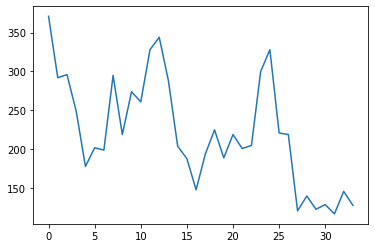

In [15]:
returns = sales[sales['item_cnt_day'] < 0].groupby(['date_block_num']).agg({'item_cnt_day':'sum'}).reset_index()
plt.plot(returns['date_block_num'], returns['item_cnt_day']*(-1));

We can see that amount of 'returned' (negative count) items is not random across different month, therefore it's not likely to be an error.

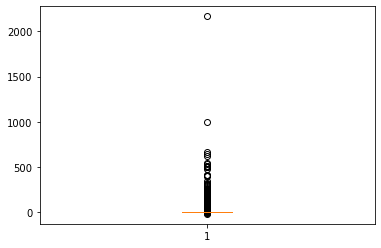

In [16]:
plt.boxplot(sales['item_cnt_day']); 

I see 2 outliars on the boxplot.

In [17]:
ind = sales['item_cnt_day'].sort_values(ascending=False)[:10].index # taking 10 most sold samples
sales.loc[ind].merge(items, on='item_id')

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_name,item_category_id
0,2015-10-28,33,12,11373,0.908714,2169.0,Доставка до пункта выдачи (Boxberry),9
1,2015-05-19,28,12,11373,155.192950,539.0,Доставка до пункта выдачи (Boxberry),9
2,2015-01-15,24,12,20949,4.000000,1000.0,Фирменный пакет майка 1С Интерес белый (34*42)...,71
3,2015-09-30,32,12,9248,1692.526158,669.0,"Билет ""ИгроМир 2015"" - 3 октября 2015 (сайт) [...",80
4,2015-09-29,32,12,9248,1500.000000,504.0,"Билет ""ИгроМир 2015"" - 3 октября 2015 (сайт) [...",80
5,2015-09-30,32,55,9249,1702.825746,637.0,"Билет ""ИгроМир 2015"" - 3 октября 2015 (сайт) У...",8
6,2015-09-29,32,55,9249,1500.000000,533.0,"Билет ""ИгроМир 2015"" - 3 октября 2015 (сайт) У...",8
7,2015-04-14,27,12,3731,1904.548077,624.0,"Grand Theft Auto V [PC, русские субтитры]",30
8,2014-10-02,21,12,9242,1500.000000,512.0,"Билет ""ИгроМир 2014"" (на один день (отдельно -...",8
9,2014-10-09,21,55,19437,899.000000,508.0,"Средиземье: Тени Мордора [PC, Цифровая версия]",31


Not sure what conclusions to draw here. Selling 1000 plastic bags at once seems tangible, however selling 533 and 637 tickets in two consecutive days seems too much.

Distributions of counts is similar to prices' distribution.

In [18]:
print(f'{round(len(sales[sales.item_cnt_day < 0])/len(sales.item_cnt_day), 3)*100}% of item counts are inadequate')

0.3% of item counts are inadequate


### Sales - conclusion

* some duplicate rows
* some inadequate values (negative prices and negative items sold) - negative items sold might be a return
* some possible outliars both in counts and prices

## Shops



In [19]:
shops.head()

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4


In [20]:
shops.isna().any().any()

False

In [21]:
shops.duplicated().any()

False

*!Якутск Орджоникидзе, 56 фран* and *Якутск Орджоникидзе, 56* probably mean the same market place, just like *!Якутск ТЦ "Центральный" фран* and *Якутск ТЦ "Центральный"*.
If this table was larger I guess we could filter shop names containing special characters and investigate them.

In [22]:
bad_shops_num = shops['shop_name'].str.contains('^[\\\/^.*\[\]~!@#$%^&()_+={}|\:;“’<,>?฿]+.*', regex= True, na=False).sum()

print(f'{round(bad_shops_num/len(shops), 2)*100}% of shop names contain special characters')

3.0% of shop names contain special characters


### Shops - conclusion

* some names start with special characters, they're also potential duplicates

## Items

In [23]:
items.head(20)

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40
5,***НОВЫЕ АМЕРИКАНСКИЕ ГРАФФИТИ (UNI) ...,5,40
6,***УДАР ПО ВОРОТАМ (UNI) D,6,40
7,***УДАР ПО ВОРОТАМ-2 (UNI) D,7,40
8,***ЧАЙ С МУССОЛИНИ D,8,40
9,***ШУГАРЛЭНДСКИЙ ЭКСПРЕСС (UNI) D,9,40


Lots of item names starting with special characters.

In [24]:
bad_names_num = items['item_name'].str.contains('^[\\\/^.*\[\]~!@#$%^&()_+={}|\:;“’<,>?฿]+.*', regex= True, na=False).sum()

print(f'{round(bad_names_num/len(items), 3)*100}% of item names contain special characters')

0.1% of item names contain special characters


In [25]:
items.isna().any().any()

False

In [26]:
items.duplicated().any()

False

### Items - conclusion

* some names start with special characters, they might be duplicates when special characters are removed

## Item categories

In [27]:
item_cat.head(10)

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4
5,Аксессуары - PSVita,5
6,Аксессуары - XBOX 360,6
7,Аксессуары - XBOX ONE,7
8,Билеты (Цифра),8
9,Доставка товара,9


Category names seem fine.

In [28]:
item_cat.isna().any().any()

False

In [29]:
item_cat.duplicated().any()

False

In [30]:
bad_cat_num = item_cat['item_category_name'].str.contains('^[\\\/^.*\[\]~!@#$%^&()_+={}|\:;“’<,>?฿]+.*', regex= True, na=False).sum()

print(f'{round(bad_cat_num/len(item_cat), 3)*100}% of item category names contain special characters')

0.0% of item category names contain special characters


## Foreign key compatibility

In [31]:
print(f'Keys that do not coincide in sales and shops: {len(set(shops.shop_id).symmetric_difference(set(sales.shop_id)))}')
print(f'Keys that do not coincide in sales and items: {len(set(items.item_id).symmetric_difference(set(sales.item_id)))}')
print(f'Keys that do not coincide in items and item categories: {len(set(items.item_category_id).symmetric_difference(set(item_cat.item_category_id)))}')

Keys that do not coincide in sales and shops: 0
Keys that do not coincide in sales and items: 363
Keys that do not coincide in items and item categories: 0


In [32]:
len(set(items['item_id']) - set(sales['item_id']))

363

Not all keys from `items` are present in the `sales`.

In [33]:
test = pd.read_csv('../data/raw/test.csv')
print(f'Keys that do not coincide in test and shops: {len(set(shops.shop_id).symmetric_difference(set(test.shop_id)))}')
print(f'Keys that do not coincide in test and items: {len(set(items.item_id).symmetric_difference(set(test.item_id)))}')

Keys that do not coincide in test and shops: 18
Keys that do not coincide in test and items: 17070


In [34]:
len(set(items['item_id']) - set(test['item_id']))

17070

In [35]:
len(set(shops['shop_id']) - set(test['shop_id']))

18

Some shops and items are not represented in `test` but there are no inknown keys.

In [36]:
print(f'Shops not mentioned in test and sales: {len(set(shops.shop_id) - set(test.shop_id).union(set(sales.shop_id)))}')
print(f'Items not mentioned in test and sales: {len(set(items.item_id) - set(test.item_id).union(set(sales.item_id)))}')

Shops not mentioned in test and sales: 0
Items not mentioned in test and sales: 0


## Potential issues with data

* small amount of duplicates in sales, needs to be handled
* item prices and item daily counts contain potential outliars and negative values
* some names of shops and items start with special characters, there's a suspition they might be duplicates ones special characters are removed

## On the other hand

* no missing data
* percentage of rows containing incorrect information is minimal (less than 1%)
* percentage of rows with string values starting with special characters is also minimal

## Data quality attributes

* Accuracy - checked
* Completeness - no missing data, we have everything to predict target (montly sales)
* Consistency - only one source of data
* Validity - checked, found some issues   
* Uniqueness - checked